In [85]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2


# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)


%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})


import warnings
warnings.filterwarnings('ignore')


from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from sklearn.model_selection import train_test_split
import Handlers as hd

In [87]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
TARGET_FEATURE = 'reviewer_score'

In [88]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [89]:
# Подгрузим наши данные из соревнования
df_train = pd.read_csv('data/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv.zip') # самбмишн

### Первичный анализ тренировочного датасета

In [90]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [91]:
df_train

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.00,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.80,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.49,-0.19
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.40,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.20,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.19,16.40
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.80,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.30,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.52,-0.13
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.10,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.20,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.52,-0.16


In [92]:
# negative_review и review_total_negative_word_counts имеют по 24% одинаковых значений, интересно
hd.get_low_inform_features_list(df_train, level=0)

hotel_address: 0.93% одинаковых значений
additional_number_of_scoring: 0.93% одинаковых значений
review_date: 0.49% одинаковых значений
average_score: 8.0% одинаковых значений
hotel_name: 0.93% одинаковых значений
reviewer_nationality: 47.58% одинаковых значений
negative_review: 24.79% одинаковых значений
review_total_negative_word_counts: 24.79% одинаковых значений
total_number_of_reviews: 0.93% одинаковых значений
positive_review: 6.95% одинаковых значений
review_total_positive_word_counts: 6.95% одинаковых значений
total_number_of_reviews_reviewer_has_given: 29.98% одинаковых значений
reviewer_score: 22.44% одинаковых значений
tags: 1.0% одинаковых значений
days_since_review: 0.49% одинаковых значений
lat: 0.93% одинаковых значений
lng: 0.93% одинаковых значений


['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'tags',
 'days_since_review',
 'lat',
 'lng']

In [93]:
# Совмем мало пропусков
hd.get_columns_isnull_info_df(df_train)

lng   0.63
lat   0.63
dtype: float64

In [94]:
# По повторам в negative_review стало понятно, это короткие однотипные комментарии
hd.get_top_unique_values(df_train)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,0.39,163 Marsh Wall Docklands Tower Hamlets London ...,3587,0.93
1,additional_number_of_scoring,480,0.12,2682,3587,0.93
2,review_date,731,0.19,8/2/2017,1911,0.49
3,average_score,34,0.01,8.40,30929,8.00
4,hotel_name,1492,0.39,Britannia International Hotel Canary Wharf,3587,0.93
5,reviewer_nationality,225,0.06,United Kingdom,184033,47.58
6,negative_review,248828,64.33,No Negative,95907,24.79
7,review_total_negative_word_counts,402,0.10,0,95907,24.79
8,total_number_of_reviews,1142,0.30,9086,3587,0.93
9,positive_review,311737,80.59,No Positive,26885,6.95


### Первичный анализ тестового датасета

In [95]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [96]:
df_test

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.10,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.53,9.17
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.60,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.39,4.83
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.30,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.39,2.16
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.10,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.48,9.20
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.10,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.37,4.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128930,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,2/3/2016,8.10,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,4,14,"[' Business trip ', ' Couple ', ' Double Room ...",547 day,45.50,9.22
128931,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,6/18/2016,7.80,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,24,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",411 day,41.38,2.18
128932,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,7/6/2017,8.00,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,1,"[' Business trip ', ' Solo traveler ', ' Singl...",28 days,48.19,16.37
128933,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.00,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.47,9.21


In [97]:
# negative_review и review_total_negative_word_counts имеют по 24% одинаковых значений, интересно
hd.get_low_inform_features_list(df_test, level=0)

hotel_address: 0.93% одинаковых значений
additional_number_of_scoring: 0.93% одинаковых значений
review_date: 0.52% одинаковых значений
average_score: 7.98% одинаковых значений
hotel_name: 0.93% одинаковых значений
reviewer_nationality: 47.48% одинаковых значений
negative_review: 24.81% одинаковых значений
review_total_negative_word_counts: 24.81% одинаковых значений
total_number_of_reviews: 0.93% одинаковых значений
positive_review: 7.03% одинаковых значений
review_total_positive_word_counts: 7.03% одинаковых значений
total_number_of_reviews_reviewer_has_given: 29.99% одинаковых значений
tags: 0.98% одинаковых значений
days_since_review: 0.52% одинаковых значений
lat: 0.94% одинаковых значений
lng: 0.94% одинаковых значений


['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'tags',
 'days_since_review',
 'lat',
 'lng']

In [98]:
# Совмем мало пропусков
hd.get_columns_isnull_info_df(df_test)

lng   0.64
lat   0.64
dtype: float64

In [99]:
# По повторам в negative_review стало понятно, это короткие однотипные комментарии
hd.get_top_unique_values(df_test)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,1.16,163 Marsh Wall Docklands Tower Hamlets London ...,1202,0.93
1,additional_number_of_scoring,480,0.37,2682,1202,0.93
2,review_date,731,0.57,8/2/2017,674,0.52
3,average_score,34,0.03,8.40,10293,7.98
4,hotel_name,1492,1.16,Britannia International Hotel Canary Wharf,1202,0.93
5,reviewer_nationality,202,0.16,United Kingdom,61213,47.48
6,negative_review,84673,65.67,No Negative,31983,24.81
7,review_total_negative_word_counts,369,0.29,0,31983,24.81
8,total_number_of_reviews,1142,0.89,9086,1202,0.93
9,positive_review,106112,82.30,No Positive,9061,7.03


### Файл сабмишшена

In [100]:
# Нужно своими значениями заменить столбцец reviewer_score
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [101]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [102]:
df_train

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.00,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.80,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.49,-0.19
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.40,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.20,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.19,16.40
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.80,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.30,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.52,-0.13
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.10,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.20,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.52,-0.16


In [103]:
# Объединяю датафреймы для удобной обработки признаков
df_full = hd.merge_train_and_test_df(df_train, df_test, TARGET_FEATURE)

In [104]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

### Поиск дубликатов

In [105]:
df_full_dup = df_full[df_full.duplicated()]
df_full_dup

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,reviewer_score,dataset
21413,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,9/27/2015,8.90,Hotel Le Sainte Beuve,Costa Rica,No Negative,0,143,Ir s a lovely boutique hotel full of Parisian...,53,4,"[' Leisure trip ', ' Family with older childre...",676 day,48.84,2.33,10.00,train
53110,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,9/25/2016,9.00,H tel Baume,Lebanon,nothing at all,4,253,bed was great staff are wonderful location ve...,10,1,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",312 day,48.85,2.34,10.00,train
54461,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/2/2016,7.90,H tel Concorde Montparnasse,Israel,The room to far from elevator,7,2515,Staff very nice and helpful Breakfast was per...,17,2,"[' Couple ', ' Classic Twin Room ', ' Stayed 3...",366 day,48.84,2.32,8.30,train
56542,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,7/2/2017,9.00,H tel Baume,Romania,Breakfast was a huge joke It was the worst po...,19,253,Room was great nice and spacious appartment f...,14,7,"[' Leisure trip ', ' Family with young childre...",32 days,48.85,2.34,7.90,train
65789,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,8/11/2015,9.00,H tel Baume,United Kingdom,No Negative,0,253,Friendly reception staff clean bathroom and l...,11,1,"[' Leisure trip ', ' Couple ', ' Superior Doub...",723 day,48.85,2.34,10.00,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499212,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/23/2016,7.90,H tel Concorde Montparnasse,United States of America,Nothing I will stay at this hotel again on my...,24,2515,The staff was very helpful and the property w...,21,8,"[' Leisure trip ', ' Family with older childre...",437 day,48.84,2.32,0.00,test
506924,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,2/1/2016,7.90,H tel Concorde Montparnasse,Malta,beautiful wiew,3,2515,cleanness staff very friendly very helpful,7,2,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",549 day,48.84,2.32,0.00,test
509781,167 rue de Rome 17th arr 75017 Paris France,11,12/12/2016,6.80,Villa Eugenie,Canada,Listed above,3,165,It was a terrible stat unfriendly staff very ...,13,1,"[' Business trip ', ' Solo traveler ', ' Stand...",234 day,48.89,2.31,0.00,test
512237,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,9/22/2015,7.90,H tel Concorde Montparnasse,Germany,Breakfast is pretty expensive however good,8,2515,Very good location good connections with Metr...,24,5,"[' Leisure trip ', ' Group ', ' Classic Twin R...",681 day,48.84,2.32,0.00,test


In [106]:
# Количество дубликатов в тестовом и трейн датасете
df_full_dup.groupby('dataset').agg({'hotel_name': 'count'})

,hotel_name
dataset,
test,29
train,307


### Просто удалить дубликаты не могу
### Создаю бинарный признак, о том что запись дубликат

In [107]:

df_full['duplicate'] = df_full.duplicated()

In [108]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

### Анализ признаков

In [109]:
# Если количество уникальных признаков < 150 то можно жумать о переводе признака в категориальный
hd.get_top_unique_values(df_full)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,0.29,163 Marsh Wall Docklands Tower Hamlets London ...,4789,0.93
1,additional_number_of_scoring,480,0.09,2682,4789,0.93
2,review_date,731,0.14,8/2/2017,2585,0.50
3,average_score,34,0.01,8.40,41222,7.99
4,hotel_name,1492,0.29,Britannia International Hotel Canary Wharf,4789,0.93
5,reviewer_nationality,227,0.04,United Kingdom,245246,47.55
6,negative_review,330011,63.99,No Negative,127890,24.80
7,review_total_negative_word_counts,402,0.08,0,127890,24.80
8,total_number_of_reviews,1142,0.22,9086,4789,0.93
9,positive_review,412601,80.00,No Positive,35946,6.97


In [110]:
# negative_review и review_total_negative_word_counts имеют по 24% одинаковых значений, интересно
hd.get_low_inform_features_list(df_full, level=0)

hotel_address: 0.93% одинаковых значений
additional_number_of_scoring: 0.93% одинаковых значений
review_date: 0.5% одинаковых значений
average_score: 7.99% одинаковых значений
hotel_name: 0.93% одинаковых значений
reviewer_nationality: 47.55% одинаковых значений
negative_review: 24.8% одинаковых значений
review_total_negative_word_counts: 24.8% одинаковых значений
total_number_of_reviews: 0.93% одинаковых значений
positive_review: 6.97% одинаковых значений
review_total_positive_word_counts: 6.97% одинаковых значений
total_number_of_reviews_reviewer_has_given: 29.98% одинаковых значений
tags: 0.99% одинаковых значений
days_since_review: 0.5% одинаковых значений
lat: 0.93% одинаковых значений
lng: 0.93% одинаковых значений
reviewer_score: 25.0% одинаковых значений
dataset: 75.0% одинаковых значений
duplicate: 99.93% одинаковых значений


['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'tags',
 'days_since_review',
 'lat',
 'lng',
 'reviewer_score',
 'dataset',
 'duplicate']

# average_score это порядковый категориальный признак

In [111]:
# average_score есть смысл привести к категориальным значениям. либо от 0 до 10 с шагом в 1. либо от 0 до 5, типа совсем плохие балы, а потмо с шагом в 1.
# А ниже 5 вообще нет оценок. Значит логично от 5 до 10 делать
df_full['average_score'].value_counts(True) * 100

8.40   7.99
8.10   7.39
8.50   7.38
8.70   7.33
8.60   7.16
8.20   6.76
8.30   6.38
8.80   5.98
8.90   5.53
8.00   4.33
9.10   4.15
9.00   4.08
7.80   3.86
7.90   2.95
7.50   2.66
9.20   2.51
9.30   2.45
7.70   2.29
9.40   1.81
7.10   1.31
7.60   1.30
7.40   1.22
7.30   0.78
7.00   0.76
6.90   0.34
6.80   0.26
9.50   0.23
6.40   0.23
6.70   0.19
9.60   0.18
7.20   0.13
6.60   0.08
5.20   0.01
9.80   0.01
Name: average_score, dtype: float64

In [112]:
df_full['average_score'].describe()

count   515738.00
mean         8.40
std          0.55
min          5.20
25%          8.10
50%          8.40
75%          8.80
max          9.80
Name: average_score, dtype: float64

### Варианты разбиения average_score на категории

In [113]:
# df_full['average_score_cat'] = pd.cut(df_full['average_score'], bins=[5, 6, 7, 8, 9, 10], include_lowest=True)
# df_full['average_score_cat'] = pd.cut(df_full['average_score'], bins=list(np.arange(5, 10.5, 0.5)), include_lowest=True) # C шагом 0.5
# df_full['average_score_cat'] = pd.qcut(df_full['average_score'], q=5) # 5 бинов с примерно одинаковым распределением внутри

df_full['average_score_cat'] = pd.cut(df_full['average_score'], bins=[5, 7, 7.5, 8, 8.5, 9, 9.5, 10], labels=['5-6', '7', '7+', '8', '8+', '9', '9+'], include_lowest=True)

In [114]:
df_full['average_score_cat'].value_counts(True) * 100

8     35.90
8+    30.08
7+    14.73
9     11.15
7      6.10
5-6    1.85
9+     0.18
Name: average_score_cat, dtype: float64

In [115]:
df_full['average_score_cat'].cat.categories

Index(['5-6', '7', '7+', '8', '8+', '9', '9+'], dtype='object')

In [118]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

In [117]:
vals = {'lat': df_full['lat'].median(),
        'lng': df_full['lng'].median()}
df_full.fillna(value=vals, inplace=True)

In [14]:
# df_full['lat'] = df_full['lat'].fillna(df_full['lat'].median(), inplace=True)
# df_full['lng'] = df_full['lng'].fillna(df_full['lng'], inplace=True)

<AxesSubplot:>

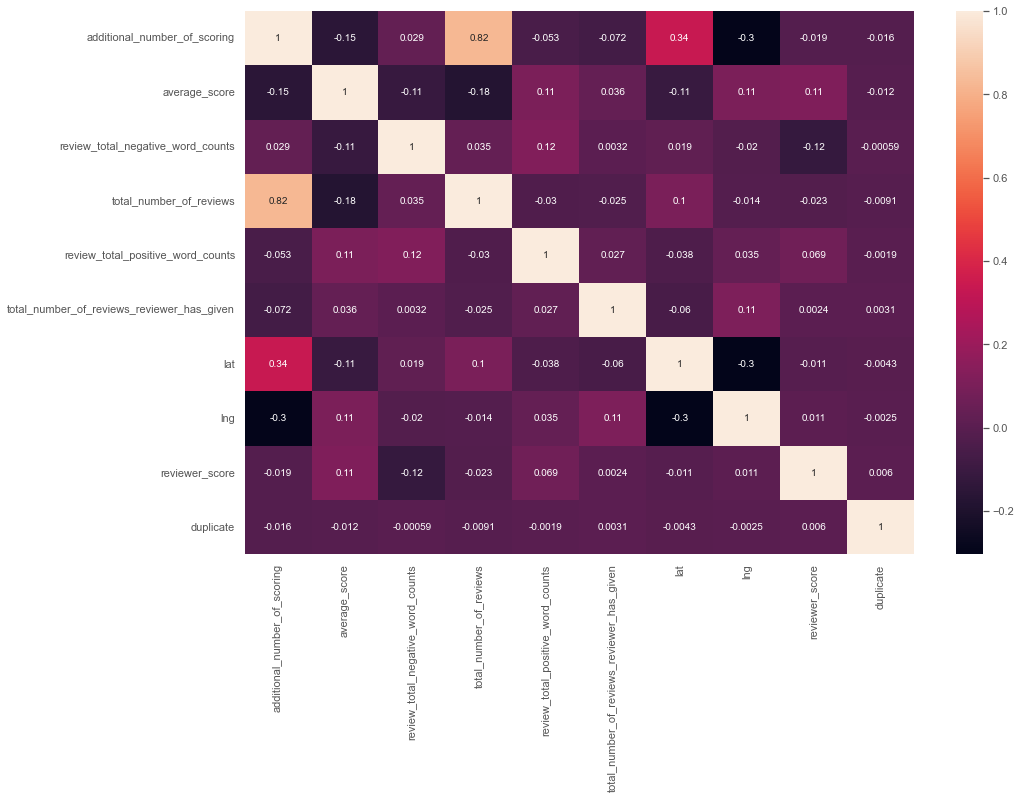

In [48]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_full.drop(['sample'], axis=1).corr(), annot=True)

In [49]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df_full.columns if df_full[s].dtypes == 'object']
object_columns
# df_full.drop(object_columns, axis = 1, inplace=True)

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'dataset',
 'sample']

In [50]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

In [53]:
# Теперь выделим тестовую часть
train_data = df_full.query('dataset == "train"').drop(['dataset'], axis=1)
test_data = df_full.query('dataset == "test"').drop(['dataset'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [54]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [55]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 20), (386803, 20), (386803, 19), (309442, 19), (77361, 19))

In [22]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [23]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [24]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отеля в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [25]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9823059147830512


<AxesSubplot:>

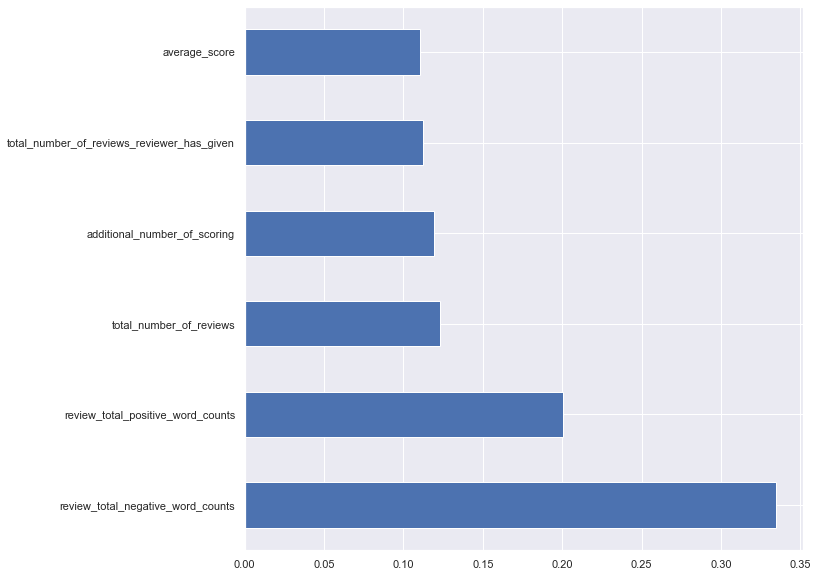

In [26]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [27]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score
60386,18,8.30,0,156,19,13,0.00
89679,239,8.40,2,2349,8,36,0.00
112015,926,8.20,26,5770,23,8,0.00
48318,235,9.30,0,769,21,3,0.00
127285,417,6.70,67,2400,2,1,0.00
112783,420,8.60,2,4379,12,1,0.00
59772,234,9.30,0,1075,25,1,0.00
36422,387,8.50,0,1593,44,1,0.00
60932,119,8.90,0,394,16,19,0.00
76790,147,8.60,36,1562,32,52,0.00


In [28]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [29]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [30]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [31]:
predict_submission

array([8.502 , 8.08  , 7.968 , ..., 8.43  , 9.617 , 7.9375])

In [32]:
list(sample_submission)

['reviewer_score', 'id']

In [33]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.50,488440
1,8.08,274649
2,7.97,374688
3,9.52,404352
4,9.42,451596
5,8.83,302161
6,6.80,317079
7,7.82,13963
8,9.13,159785
9,8.11,195089


In [34]:
sample_submission

,reviewer_score,id
0,8.50,488440
1,8.08,274649
2,7.97,374688
3,9.52,404352
4,9.42,451596
...,...,...
128930,9.12,495812
128931,5.74,315577
128932,8.43,511968
128933,9.62,303386
